# Goal

Create vectors from some Shakespeare text

In [3]:
import codecs #Word encoding
import glob #Regex
import multiprocessing #Concurrency
import os #Dealing ops with system
import pprint #Pretty printing
import re #Regular expression
import nltk #NLP library
import gensim.models.word2vec as w2v #Word2Vec
import sklearn.manifold #Dimensionality reduction
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Step 1 - Process our data

In [4]:
nltk.download('punkt') #Pretrained tokenizer
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alber\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alber\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Get the book names, matching txt file

In [7]:
filenames = ['got1.txt']
filenames

['got1.txt']

In [8]:
corpus_raw = u""
for filename in filenames:
    print('Reading %s' % filename)
    with codecs.open(filename,'r','utf-8') as file:
        corpus_raw += file.read()
    print('Corpus in now %d characters long' % len(corpus_raw))
    print()

Reading got1.txt
Corpus in now 1770659 characters long



## Step 2 - Split the corpus into sentences

In [9]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [10]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [11]:
print('There are %d sentences' % len(raw_sentences))

There are 23532 sentences


Convert into a list of words

In [12]:
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-z]"," ",raw)
    words = clean.split()
    return words

In [13]:
#Sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if(len(raw_sentence) > 0):
        sentences.append(sentence_to_wordlist(raw_sentence))

In [14]:
print('Example:')
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

Example:
Heraldic crest by Virginia Norey.
['Heraldic', 'crest', 'by', 'Virginia', 'Norey']


In [15]:
token_count = sum([len(sentence) for sentence in sentences])
print('The book corpus contains %d tokens' % token_count)

The book corpus contains 331572 tokens


## Step 3 - Train Word2Vec

Once we have vectores, 3 main tasks:
 - Distance
 - Similarity
 - Ranking
 
Let's define some hyperparameters

In [39]:
#Dimensionality of the resulting vectores
num_features = 300

#Minimum count threshold
min_word_count = 3

#Number of threads to run in parallel
num_workers = multiprocessing.cpu_count() #Returns the number of CPUs in the system

#Context windows size
context_size = 7

#Downsample setting for frequent words
downsampling = 1e-3 #Not see too many times the most frequent words...

#Seed for the randomnessss, to make results reproducible
seed = 1

In [40]:
got2Vec = w2v.Word2Vec(sg=1,
                           seed=seed,
                           workers=num_workers,
                           size=num_features,
                           min_count=min_word_count,
                           window=context_size,
                           sample=downsampling
)

In [41]:
got2Vec.build_vocab(sentences)

In [42]:
print('Word2Vec vocabulary length: %d' % got2Vec.corpus_count)

Word2Vec vocabulary length: 23532


# Step 4 - Train the model

In [43]:
got2Vec.train(sentences=sentences,total_examples=got2Vec.corpus_count,epochs=got2Vec.iter)

1239728

**Yay, save to file!**

In [44]:
got2Vec.save('got2Vec.w2v')

## Step 5 - Explore the trained model

In [45]:
got2Vec = w2v.Word2Vec.load('got2Vec.w2v')

Compress for visualization

In [46]:
tsne = sklearn.manifold.TSNE(n_components=2,random_state=0)

In [48]:
all_word_vectors_matrix = got2Vec.syn1neg

In [49]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [60]:
print('Sample - Extended dimensionality\n%s' % all_word_vectors_matrix[0][:10])
print('Sample - Reduced dimensionality\n%s' % all_word_vectors_matrix_2d[0])

Sample - Extended dimensionality
[-0.05692078  0.15174794  0.01443612 -0.00372962  0.12213861 -0.02573039
 -0.068853    0.02093502  0.09939608  0.12585592]
Sample - Reduced dimensionality
[-0.14206009 -1.72798145]


#### Plot time

In [64]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[got2Vec.wv.vocab[word].index])
            for word in got2Vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [65]:
points.head()

,word,x,y
0,bowing,9.686992,2.286710
1,laces,-4.561524,-6.679483
2,phrase,9.604645,2.534248
3,smack,-1.839290,-6.062844
4,curious,2.886270,3.816394


In [66]:
import seaborn as sns
%pylab inline
sns.set_context('poster')

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


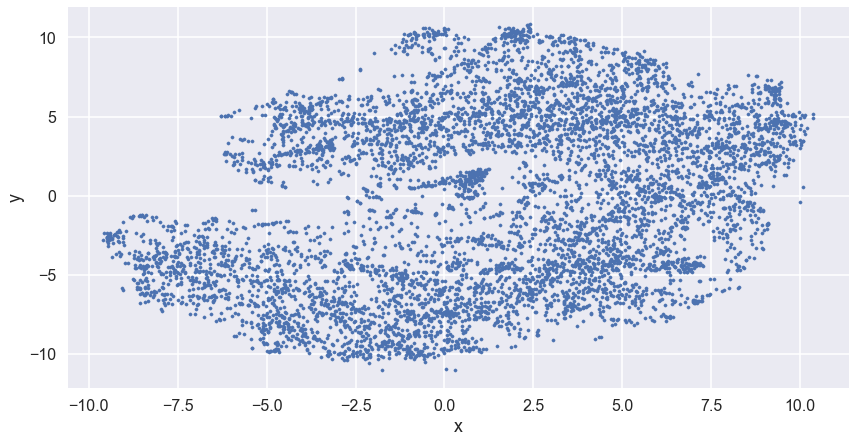

In [72]:
points.plot.scatter('x','y',s=10,figsize=(14,7));

### Zoom in to some interesting places

In [68]:
def plot_region(x_bounds,y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) &
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter('x','y',s=50,figsize=(10,8))
    for i,point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word,fontsize=11)

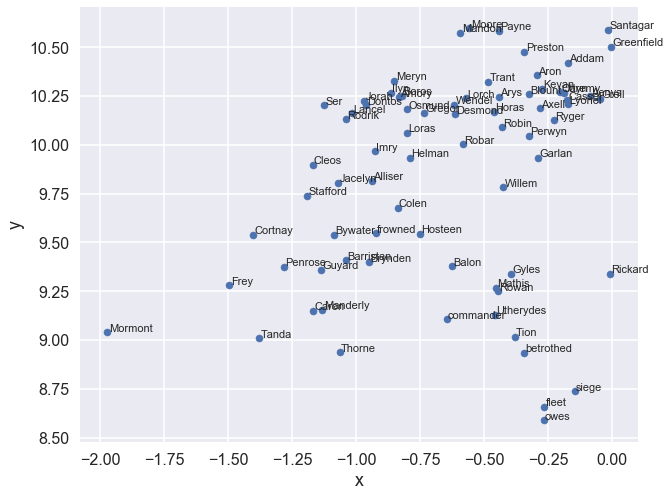

In [73]:
plot_region(x_bounds=(-2,0),y_bounds=(8,11))

### Explore semantic similarities

In [82]:
got2Vec.most_similar("wall")

[('earth', 0.9616312384605408),
 ('low', 0.9566549062728882),
 ('lake', 0.9536454677581787),
 ('rock', 0.9495635032653809),
 ('wind', 0.9490193128585815),
 ('curtain', 0.9479524493217468),
 ('bars', 0.9475040435791016),
 ('deck', 0.9471420049667358),
 ('stony', 0.9469695091247559),
 ('wagon', 0.9467599987983704)]

In [80]:
got2Vec.most_similar("morghulis")

[('Valar', 0.994759202003479),
 ('thirsty', 0.9927442073822021),
 ('language', 0.9911553263664246),
 ('possessed', 0.9901469945907593),
 ('gloomily', 0.9901279807090759),
 ('grand', 0.9900002479553223),
 ('excused', 0.9889438152313232),
 ('whimpered', 0.9888014793395996),
 ('resigned', 0.9886830449104309),
 ('miserably', 0.9886272549629211)]

In [83]:
got2Vec.most_similar("Cersei")

[('Joff', 0.9162287712097168),
 ('babe', 0.9090884923934937),
 ('Joffrey', 0.9073415398597717),
 ('Jaime', 0.9071990251541138),
 ('Selyse', 0.9033643007278442),
 ('Lancel', 0.901087760925293),
 ('Tommen', 0.8952292203903198),
 ('Brienne', 0.888649582862854),
 ('Myrcella', 0.8875987529754639),
 ('Littlefinger', 0.8821403980255127)]

In [86]:
def nearest_similarity_cosmul(start1,end1,end2):
    similarities = got2Vec.most_similar_cosmul(
        positive = [end2,start1,],
        negative = [end1]
    )
    start2 = similarities[0][0]
    
    print('%s is related to %s as %s is related to %s' %(start1,end1,start2,end2))
    return start2

In [94]:
nearest_similarity_cosmul("snow","North","Westeros")

snow is related to North as fish is related to Westeros


'fish'